In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
raw_df = pd.read_csv('/workspaces/FDA-FAEERS-Data-Analysis/data/raw/unclean_smartwatch_health_data.csv')
raw_df.head()

,User ID,Heart Rate (BPM),Blood Oxygen Level (%),Step Count,Sleep Duration (hours),Activity Level,Stress Level
0,4174.0,58.939776,98.809650,5450.390578,7.167235622316564,Highly Active,1
1,NaN,NaN,98.532195,727.601610,6.538239375570314,Highly_Active,5
2,1860.0,247.803052,97.052954,2826.521994,ERROR,Highly Active,5
3,2294.0,40.000000,96.894213,13797.338044,7.367789630207228,Actve,3
4,2130.0,61.950165,98.583797,15679.067648,NaN,Highly_Active,6


# Analysis on the raw data

In [11]:
#Raw statistics
raw_df.describe(include='all')

,User ID,Heart Rate (BPM),Blood Oxygen Level (%),Step Count,Sleep Duration (hours),Activity Level,Stress Level
count,9799.000000,9600.000000,9700.000000,9900.000000,9850,9800,9800
unique,NaN,NaN,NaN,NaN,9604,6,11
top,NaN,NaN,NaN,NaN,ERROR,Seddentary,2
freq,NaN,NaN,NaN,NaN,247,1676,1007
mean,3007.480253,76.035462,97.841581,6985.685885,NaN,NaN,NaN
std,1150.581542,19.412483,1.732863,6885.809680,NaN,NaN,NaN
min,1001.000000,40.000000,90.791208,0.910138,NaN,NaN,NaN
25%,1997.500000,64.890152,96.662683,2021.039657,NaN,NaN,NaN
50%,2998.000000,75.220601,98.010642,4962.534599,NaN,NaN,NaN
75%,4004.000000,85.198249,99.376179,9724.902880,NaN,NaN,NaN


In [16]:
# Missing values count
missing_values = raw_df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 User ID                   201
Heart Rate (BPM)          400
Blood Oxygen Level (%)    300
Step Count                100
Sleep Duration (hours)    150
Activity Level            200
Stress Level              200
dtype: int64


In [20]:
# Analysing the data type in each column and checking for multiple data types in a single column
data_types = raw_df.dtypes
print("Data types in each column:\n", data_types)

Data types in each column:
 User ID                   float64
Heart Rate (BPM)          float64
Blood Oxygen Level (%)    float64
Step Count                float64
Sleep Duration (hours)     object
Activity Level             object
Stress Level               object
dtype: object


In [32]:
# Analysing the non-numeric columns

raw_df.select_dtypes(include=['object']).value_counts()

Sleep Duration (hours)  Activity Level  Stress Level
ERROR                   Active          1               10
                                        9                9
                        Seddentary      5                8
                        Highly_Active   10               7
                        Seddentary      9                7
                                                        ..
5.8119374361711325      Highly Active   5                1
5.8124309845041795      Sedentary       7                1
5.813005108606799       Active          8                1
5.81303719597394        Active          10               1
5.809913631493339       Actve           5                1
Name: count, Length: 9276, dtype: int64

In [27]:
# Detecting non-numeric entries in numeric columns
for column in raw_df.select_dtypes(include=['float64', 'int64']).columns:
    non_numeric = raw_df[column].apply(lambda x: not isinstance(x, (int, float)) and pd.notnull(x))
    if non_numeric.any():
        print(f"Non-numeric entries found in column '{column}':")
        print(raw_df[non_numeric][column])

In [28]:
# Detecting non-numeric entries in object based columns (Sleeping hours, Stress Level)
for column in raw_df.columns:
    if raw_df[column].dtype == 'object':
        
        # Skip activity level as it is categorical
        if column == 'Activity Level':
            continue
        non_numeric_entries = raw_df[~raw_df[column].apply(lambda x: isinstance(x, (int, float)) or (isinstance(x, str) and x.replace('.', '', 1).isdigit()))][column]
        if not non_numeric_entries.empty:
            print(f"Non-numeric entries found in column '{column}':\n", non_numeric_entries.unique())

Non-numeric entries found in column 'Sleep Duration (hours)':
 ['ERROR' '-0.1944527906201543']
Non-numeric entries found in column 'Stress Level':
 ['Very High']


In [29]:
# Verify data types in 'Stress Level' column
print("Unique entries in 'Stress Level' column:\n", raw_df['Stress Level'].unique())

Unique entries in 'Stress Level' column:
 ['1' '5' '3' '6' '10' '2' '8' '9' nan '4' 'Very High' '7']


# Analysis so far

- A small percentage of missing values in the dataset (~1% to 4% on each column)
- Non-numeric values in 'Sleep Duration' and 'Stress Level' columns
- Categorical values in 'Activity Level' column needs to be standardized
- 'Very High' is a single non-numeric value present in 'Stress-Level' column. Need to encode it to a numeric value

---

# Data cleaning and preprocesing

In [39]:
# Deciding on whether to impute or drop missing values based on their distribution by intersecting missing value counts of all columns

missing_value_df = pd.DataFrame(missing_values, columns=['Missing Count'])
missing_value_df['Total Count'] = len(raw_df)
missing_value_df['Missing Percentage'] = (missing_value_df['Missing Count'] / missing_value_df['Total Count']) * 100
print(missing_value_df)


# Counting the total number missing values from the intersection of all columns
total_missing_intersection = raw_df.isnull().all(axis=1).sum()
print(f"Total number of rows with missing values across all columns: {total_missing_intersection}")
if total_missing_intersection > 0:
    print("These rows can be dropped as they have missing values in all columns.")
else:
    print("No rows have missing values across all columns.")


# Total missing values percentage
total_missing = raw_df.isnull().sum().sum()
total_values = raw_df.size
missing_percentage = (total_missing / total_values) * 100
print(f"Total missing values: {total_missing} out of {total_values} ({missing_percentage:.2f}%)")

                        Missing Count  Total Count  Missing Percentage
User ID                           201        10000                2.01
Heart Rate (BPM)                  400        10000                4.00
Blood Oxygen Level (%)            300        10000                3.00
Step Count                        100        10000                1.00
Sleep Duration (hours)            150        10000                1.50
Activity Level                    200        10000                2.00
Stress Level                      200        10000                2.00
Total number of rows with missing values across all columns: 0
No rows have missing values across all columns.
Total missing values: 1551 out of 70000 (2.22%)


---

- Total missing values are very low so it's better to drop them instead of imputing them. 
- Imputing them will not give valuable impacts except the scenario when a large part of dataset is missing.

---

In [54]:
# Standardizing all column names to lowercase and replacing spaces with underscores
from os import rename


raw_df.columns = raw_df.columns.str.lower().str.replace(' ', '_')

raw_df = raw_df.rename(columns={
    'blood_oxygen_level_(%)': 'blood_oxygen_level_percent',
    'heart_rate_(bpm)': 'heart_rate_bpm',
    'sleep_duration_(hours)': 'sleep_duration_hours'
})

print('Column names after standardization:\n', [i for i in raw_df.columns])

Column names after standardization:
 ['user_id', 'heart_rate_bpm', 'blood_oxygen_level_percent', 'step_count', 'sleep_duration_hours', 'activity_level', 'stress_level']


In [63]:
# Dropping rows with missing values in any column
raw_df_cleaned = raw_df.dropna(how='any')
print(f"Data shape before and after dropping rows with all missing values: {raw_df.shape} -> {raw_df_cleaned.shape}")


Data shape before and after dropping rows with all missing values: (10000, 7) -> (8543, 7)


In [64]:

# Removing rows with 'ERROR' in 'sleep_duration_hours' column
raw_df_cleaned = raw_df_cleaned[raw_df_cleaned['sleep_duration_hours'] != 'ERROR']
print(f"Data shape after removing 'ERROR' entries in 'sleep_duration_hours': {raw_df_cleaned.shape}")


Data shape after removing 'ERROR' entries in 'sleep_duration_hours': (8325, 7)


In [65]:

# Changing 'Very High' to 10 in 'stress_level' column
raw_df_cleaned['stress_level'] = raw_df_cleaned['stress_level'].replace('Very High', 10)


In [66]:

# Converting data types: sleep_duration_hours to float, stress_level to int
raw_df_cleaned['sleep_duration_hours'] = pd.to_numeric(raw_df_cleaned['sleep_duration_hours'], errors='coerce')
raw_df_cleaned['stress_level'] = pd.to_numeric(raw_df_cleaned['stress_level'], errors='coerce', downcast='integer')

In [67]:
raw_df_cleaned.dtypes

user_id                       float64
heart_rate_bpm                float64
blood_oxygen_level_percent    float64
step_count                    float64
sleep_duration_hours          float64
activity_level                 object
stress_level                     int8
dtype: object

In [68]:
# Check missing values after cleaning
missing_values_after_cleaning = raw_df_cleaned.isnull().sum()
print("Missing values in each column after cleaning:\n", missing_values_after_cleaning)

Missing values in each column after cleaning:
 user_id                       0
heart_rate_bpm                0
blood_oxygen_level_percent    0
step_count                    0
sleep_duration_hours          0
activity_level                0
stress_level                  0
dtype: int64


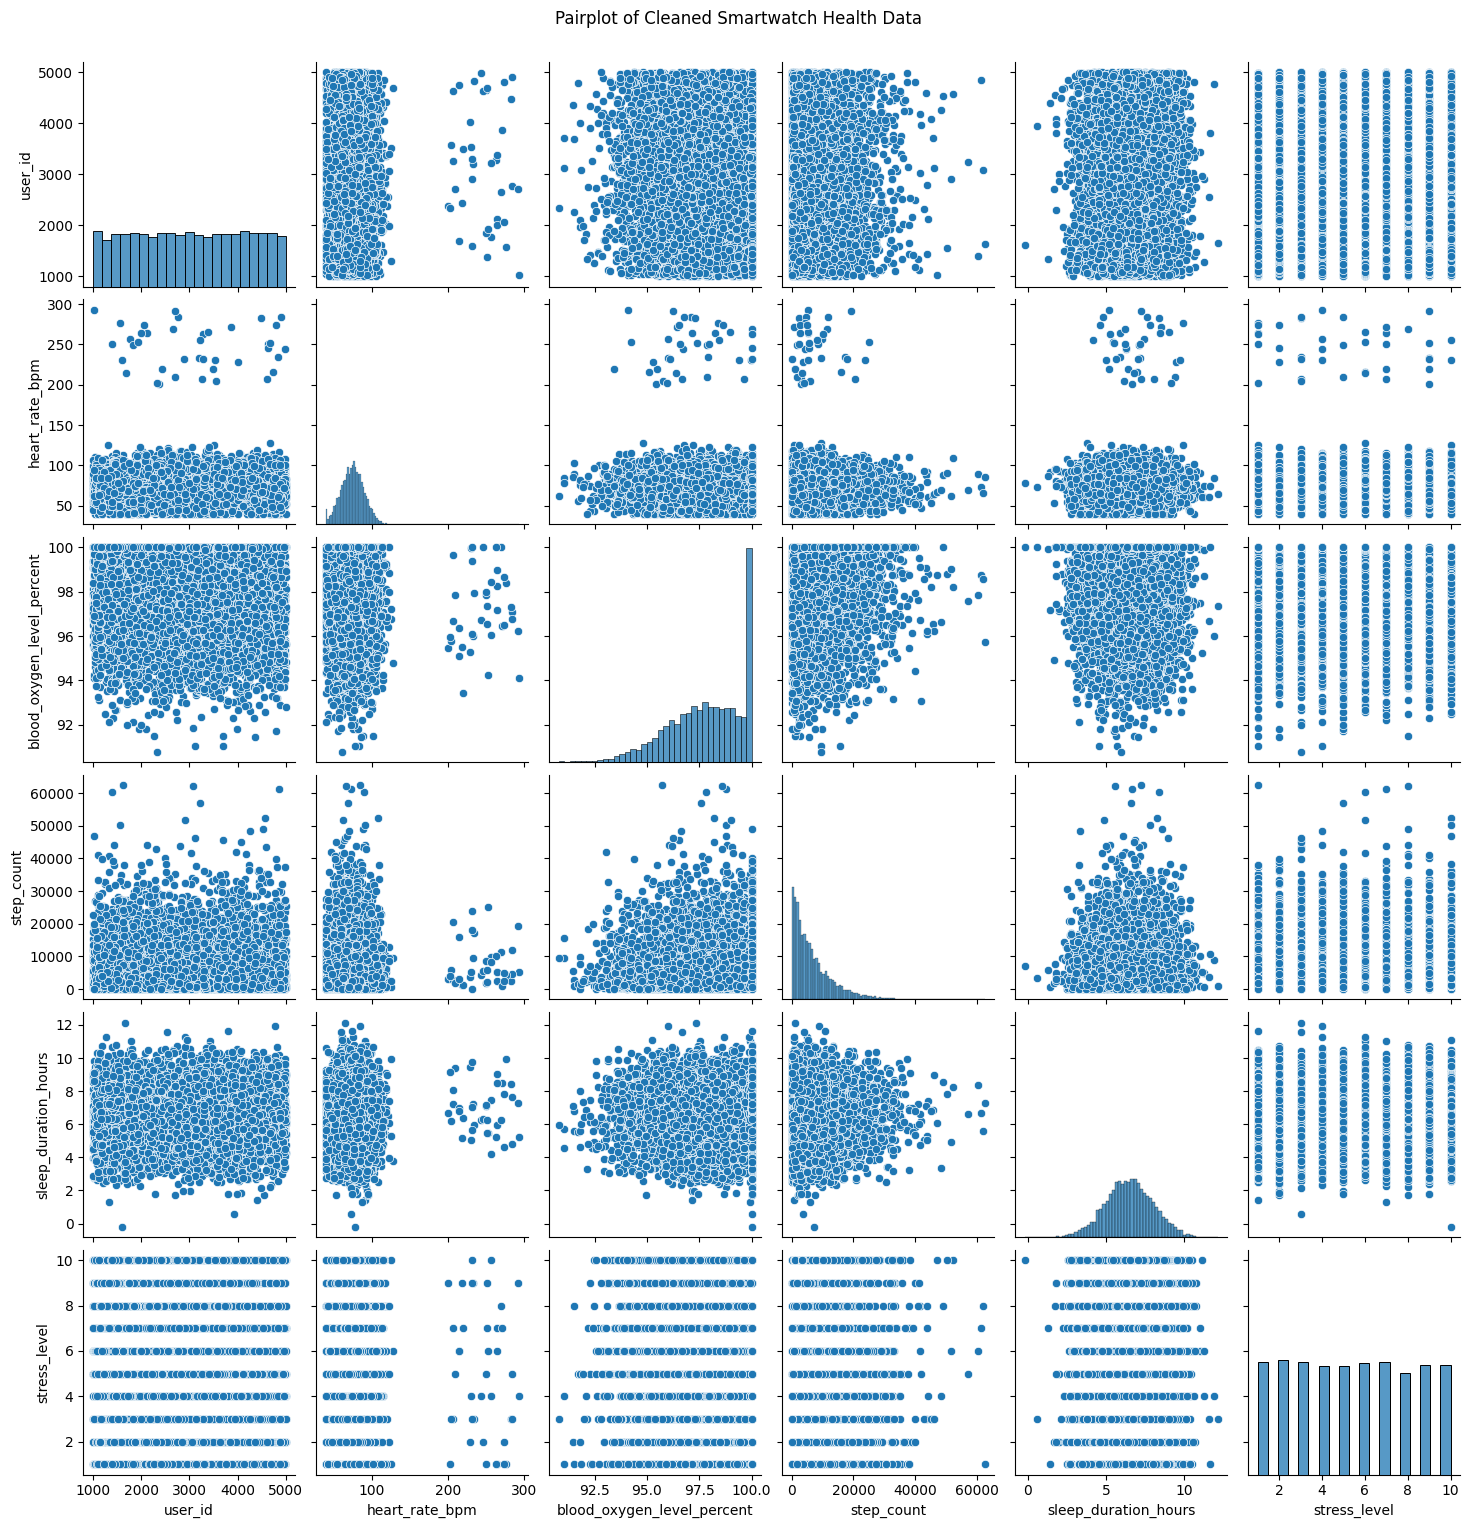

In [69]:
# Visualizing after data cleaning
sns.pairplot(raw_df_cleaned)
plt.suptitle('Pairplot of Cleaned Smartwatch Health Data', y=1.02)
plt.show() 